<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220818.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis 
* iterator

In [1]:
import pandas as pd
import numpy as np 
import plotnine as gg
from plotnine import ggplot, aes
from datetime import datetime, date, time, timezone, timedelta 

import re 
import os

from functools import reduce 
from collections import defaultdict, Counter, ChainMap

# customer analysis

In [2]:
os.listdir()

['.config',
 'ecommerce-data.csv',
 'online_retail_II.xlsx',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'sample_data']

In [3]:
df = pd.read_excel('online_retail_II.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df.columns = ['_'.join(re.split(r'(?=[A-Z][a-z])', a[0].lower() + a[1:])).lower().replace(' ', '_') for a in df.columns]
df.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
df = df[(~df.invoice.astype(str).str.contains('C')) & (df.country == 'United Kingdom')]
df.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
df.invoice_date = df.invoice_date.to_numpy().astype('datetime64[ns]')
df['date'] = df.invoice_date.to_numpy().astype('datetime64[D]')
df['month'] = df.invoice_date.to_numpy().astype('datetime64[M]')
df['rev'] = df.quantity * df.price

df = df[['customer_id', 'month', 'date', 'rev']].rename(columns = {'customer_id':'id'})
df = df.groupby(['id','month','date'])['rev'].sum().reset_index()
df.head()

,id,month,date,rev
0,12346.0,2009-12-01,2009-12-14,90.0
1,12346.0,2009-12-01,2009-12-18,23.5
2,12346.0,2010-01-01,2010-01-04,45.0
3,12346.0,2010-01-01,2010-01-14,22.5
4,12346.0,2010-01-01,2010-01-22,22.5


In [8]:
list_pu = df.groupby(['id','month'])['rev'].sum().reset_index().sort_values(['id','month'], ascending = [1,1])
list_npu = list_pu.groupby(['id']).first().reset_index()
list_mon = list_npu['month'].sort_values().unique()

In [10]:
res = []
for mon in list_mon : 
  temp_npu = list_npu[list_npu['month'] == mon] 
  temp_pu = list_pu[list_pu['id'].isin(temp_npu['id'])]
  temp = temp_pu.groupby(['month'])['id'].count().reset_index().rename(columns = {'id':'pu'})
  temp = temp.assign(npu_month = str(mon)[:10],
                     num = temp['month'].rank(),
                     ratio = lambda x : round(x['pu']/x['pu'].max() * 100, 2)
                     )
  
  temp = temp[['npu_month', 'num', 'pu', 'ratio']]
  res.append(temp)

res = pd.concat(res, axis = 0)
res = pd.melt(res, id_vars = ['npu_month', 'num'], var_name = 'type')
res.head()

,npu_month,num,type,value
0,2009-12-01,1.0,pu,904.0
1,2009-12-01,2.0,pu,318.0
2,2009-12-01,3.0,pu,298.0
3,2009-12-01,4.0,pu,382.0
4,2009-12-01,5.0,pu,342.0


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


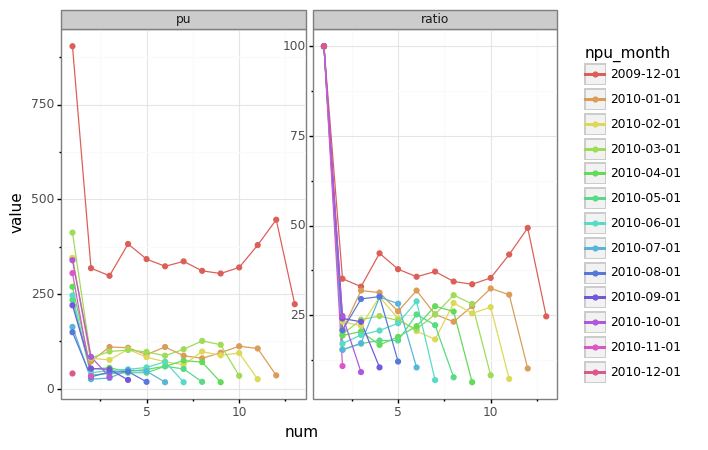

<ggplot: (8786909379997)>

In [11]:
(
    ggplot(res, aes('num', 'value', color = 'npu_month')) +
    gg.geom_line() +
    gg.geom_point() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

In [14]:
info_m = df.groupby(['id', 'month'])['rev'].sum().reset_index().rename(columns = {'rev':'money'})
info_m = pd.pivot_table(info_m, index = 'id', columns = 'month', values = 'money').reset_index()
info_m = pd.melt(info_m, id_vars = 'id', var_name = 'month', value_name = 'money').reset_index().sort_values(['id','month'], ascending = [1,0])
info_m = info_m.groupby(['id']).head(3)
info_m = info_m.groupby(['id'])['money'].sum().reset_index()
info_m.head()

,id,money
0,12346.0,0.00
1,12608.0,415.79
2,12745.0,0.00
3,12746.0,0.00
4,12747.0,1801.06


In [15]:
info_f = df.groupby(['id', 'month'])['rev'].count().reset_index().rename(columns = {'rev':'freq'})
info_f = pd.pivot_table(info_f, index = 'id', columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = 'id', var_name = 'month', value_name = 'freq').reset_index().sort_values(['id','month'], ascending = [1,0])
info_f = info_f.groupby(['id']).head(3)
info_f = info_f.groupby(['id'])['freq'].sum().reset_index()
info_f.head()

,id,freq
0,12346.0,0.0
1,12608.0,1.0
2,12745.0,0.0
3,12746.0,0.0
4,12747.0,4.0


In [16]:
date_max = (df['date'] + pd.offsets.MonthEnd(0)).max()
date_max

Timestamp('2010-12-31 00:00:00')

In [17]:
info_r = df.groupby(['id']).agg({'date':lambda x : (date_max - x.max()).days}).reset_index().rename(columns = {'date':'recency'})
info_r.head()

,id,recency
0,12346.0,186
1,12608.0,61
2,12745.0,143
3,12746.0,197
4,12747.0,26


In [19]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id')
info = info.assign(r = pd.qcut(info.recency, 5, list('54321')),
                   f = pd.qcut(info.freq.rank(method = 'first'), 5, list('12345')),
                   m = pd.qcut(info.money.rank(method = 'first'), 5, list('12345'))
                   )
info['fm'] = info.r.astype(str) + info.f.astype(str)
info.head()

,id,recency,freq,money,r,f,m,fm
0,12346.0,186,0.0,0.00,2,1,1,21
1,12608.0,61,1.0,415.79,3,2,4,32
2,12745.0,143,0.0,0.00,2,1,1,21
3,12746.0,197,0.0,0.00,2,1,1,21
4,12747.0,26,4.0,1801.06,5,5,5,55


# iterator

In [20]:
mat = [list('ABC'), list('DEF'), list('GHI')]
for r, rows in enumerate(mat) :
  for c, letters in enumerate(rows) :
    print(f'({r},{c})-{letters}')

(0,0)-A
(0,1)-B
(0,2)-C
(1,0)-D
(1,1)-E
(1,2)-F
(2,0)-G
(2,1)-H
(2,2)-I


In [21]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [24]:
{key : eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [25]:
a, b = defaultdict(list), defaultdict(dict)
for user in users : 
  for c, v in user.items() : 
    a[c].append(v)
    b[c] = v

In [26]:
a

defaultdict(list,
            {'mail': ['gregorythomas@gmail.com',
              'hintoncynthia@hotmail.com',
              'wwagner@gmail.com',
              'daniel79@gmail.com',
              'ujackson@gmail.com'],
             'name': ['Brett Holland',
              'Madison Martinez',
              'Michael Jenkins',
              'Karen Rodriguez',
              'Amber Rhodes'],
             'sex': ['M', 'F', 'M', 'F', 'F'],
             'age': [73, 29, 51, 32, 42]})

In [27]:
b

defaultdict(dict,
            {'mail': 'ujackson@gmail.com',
             'name': 'Amber Rhodes',
             'sex': 'F',
             'age': 42})